In [ ]:
# Import necessary libraries
import time
import string
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.keras import backend as K
import glob
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
import warnings
import logging
import os
warnings.filterwarnings('ignore')
def set_tf_loglevel(level):
    if level >= logging.FATAL:
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    if level >= logging.ERROR:
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
    if level >= logging.WARNING:
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
    else:
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
    logging.getLogger('tensorflow').setLevel(level)
set_tf_loglevel(logging.FATAL)

In [ ]:
directory='/Users/loic/Library/CloudStorage/GoogleDrive-loic@baconnier.com/Mon Drive/AAA_NLP_UNIV.AI/SOLAR/Data/100_pics/embedding2/'
list_samples=list(glob.glob(directory+'*.pkl'))
list_samples=list_samples
#[:2]
#list_samples

# Creation of Dataset

In [ ]:
emb_dataset=[]
for i in range(0,len(list_samples)-1):        
    image = pd.read_pickle(list_samples[i])
    emb_dataset=emb_dataset+[image]
emb_dataset=np.array(emb_dataset).reshape(-1,100,1280)
emb_dataset.shape

(3000, 100, 1280)

In [ ]:
sequence_length=80
embedding_dim=1280

In [ ]:
def window_process(emb_dataset):
    ran_i = np.random.randint(0, emb_dataset.shape[1]-sequence_length+1)
    dataset=emb_dataset[:,ran_i:ran_i+sequence_length+1,:]
    return (dataset[:,:-1,:],dataset[:,-1,:])

toto=window_process(emb_dataset)
toto[0].shape,toto[1].shape

((3000, 80, 1280), (3000, 1280))

In [ ]:
from sklearn.model_selection import train_test_split
train_emb_dataset,test_emb_dataset=train_test_split(emb_dataset)
train_emb_dataset.shape

(2250, 100, 1280)

In [ ]:
#from sklearn import preprocessing
# Normalize Training Data 
#MinMaxScaler = preprocessing.MinMaxScaler().fit(train_emb_dataset)
#train_emb_dataset = MinMaxScaler.transform(train_emb_dataset)
#test_emb_dataset = MinMaxScaler.transform(test_emb_dataset)


In [ ]:
# Build Data Pipelines using TF Dataset

# Set batch size to 256 and train shuffle buffer size to 5000

batch_size = 512
train_shuffle_buffer_size = 128

train_data = tf.data.Dataset.from_tensor_slices(train_emb_dataset)
test_data = tf.data.Dataset.from_tensor_slices(test_emb_dataset)
train_data

<TensorSliceDataset element_spec=TensorSpec(shape=(100, 1280), dtype=tf.float32, name=None)>

In [ ]:

# Apply all data processing logic
train_data = train_data.shuffle(buffer_size=train_shuffle_buffer_size)
train_data = train_data.batch(batch_size)
train_data = train_data.map(window_process, num_parallel_calls=AUTOTUNE)
train_data = train_data.prefetch(AUTOTUNE)

test_data = test_data.shuffle(buffer_size=train_shuffle_buffer_size)
test_data = test_data.batch(batch_size)
test_data = test_data.map(window_process, num_parallel_calls=AUTOTUNE)
test_data = test_data.prefetch(AUTOTUNE)
print("train_data",train_data)

train_data <PrefetchDataset element_spec=(TensorSpec(shape=(None, 80, 1280), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1280), dtype=tf.float32, name=None))>


# Creation of a dummy model

In [ ]:
MAX_EPOCHS = 50

def compile_and_fit(model, train_data, patience=1):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,)
  loss=tf.keras.losses.MeanSquaredLogarithmicError(
    reduction="auto", name="mean_squared_logarithmic_error"
    )
  #loss=tf.keras.losses.MeanSquaredError()
  loss=tf.keras.losses.LogCosh(reduction="auto", name="log_cosh")
  model.compile(loss=loss,
                optimizer=tf.keras.optimizers.Adam())

  history = model.fit(train_data,validation_data=test_data, epochs=MAX_EPOCHS,callbacks=[early_stopping])
  return history

Epoch 1/50
5/5 [==============================] - 7s 797ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 2/50
5/5 [==============================] - 2s 360ms/step - loss: 0.0012 - val_loss: 9.1589e-04
Epoch 3/50
5/5 [==============================] - 2s 361ms/step - loss: 7.9852e-04 - val_loss: 5.7272e-04
Epoch 4/50
5/5 [==============================] - 2s 349ms/step - loss: 4.3756e-04 - val_loss: 3.1107e-04
Epoch 5/50
5/5 [==============================] - 2s 343ms/step - loss: 2.5193e-04 - val_loss: 1.9072e-04
Epoch 6/50
5/5 [==============================] - 2s 375ms/step - loss: 1.3899e-04 - val_loss: 1.2944e-04
Epoch 7/50
5/5 [==============================] - 2s 345ms/step - loss: 8.7835e-05 - val_loss: 7.7660e-05
Epoch 8/50
5/5 [==============================] - 2s 341ms/step - loss: 5.9071e-05 - val_loss: 5.2627e-05
Epoch 9/50
5/5 [==============================] - 2s 343ms/step - loss: 4.0718e-05 - val_loss: 3.6638e-05
Epoch 10/50
5/5 [==============================] - 2s 347m

<AxesSubplot: >

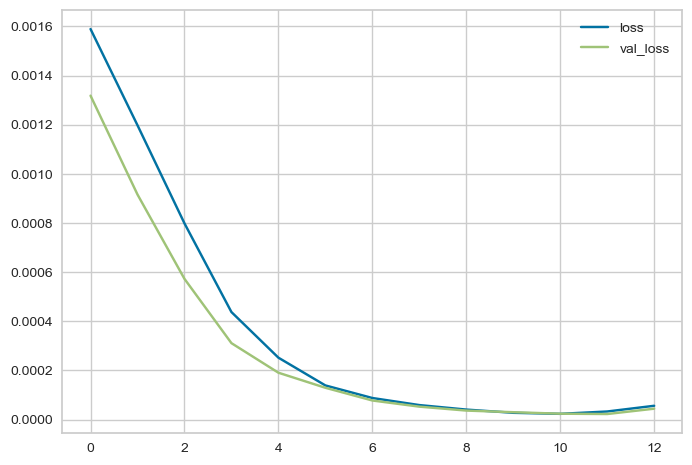

In [ ]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dense(units=embedding_dim)
])

history = compile_and_fit(lstm_model, train_data)

pd.DataFrame(history.history).plot()
             

In [ ]:
nb=3000
sample=toto[0][:nb]
real=toto[1][:nb]
predict=lstm_model.predict(sample)
np.concatenate([real,predict]).shape
#res=pd
real.shape,predict.shape

94/94 [==============================] - 4s 35ms/step


((3000, 1280), (3000, 1280))

In [ ]:
#real-predict,real,predict

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6000 samples in 0.002s...
[t-SNE] Computed neighbors for 6000 samples in 1.065s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6000
[t-SNE] Computed conditional probabilities for sample 2000 / 6000
[t-SNE] Computed conditional probabilities for sample 3000 / 6000
[t-SNE] Computed conditional probabilities for sample 4000 / 6000
[t-SNE] Computed conditional probabilities for sample 5000 / 6000
[t-SNE] Computed conditional probabilities for sample 6000 / 6000
[t-SNE] Mean sigma: 0.000823
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.953514
[t-SNE] KL divergence after 300 iterations: 1.862233


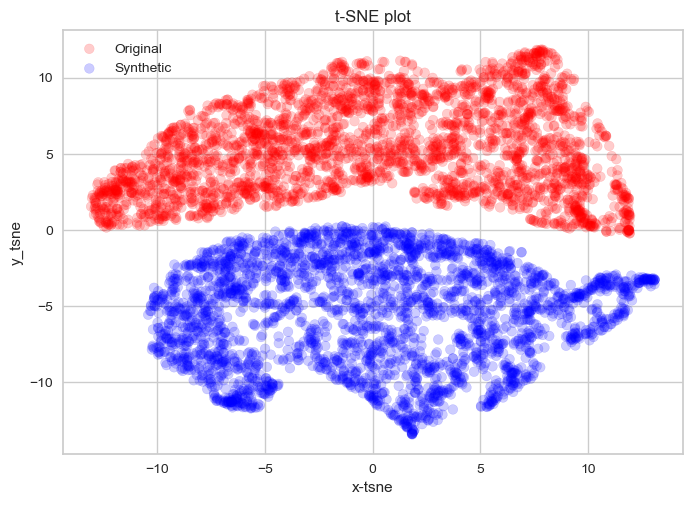

In [ ]:

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Do t-SNE Analysis together       
prep_data_final = np.concatenate((real, predict), axis = 0)
anal_sample_no = len(real)
colors = ["red" for i in range(anal_sample_no)] + ["blue" for i in range(anal_sample_no)]
# TSNE anlaysis
tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40, n_iter = 300)
tsne_results = tsne.fit_transform(prep_data_final)

# Plotting
f, ax = plt.subplots(1)

plt.scatter(tsne_results[:anal_sample_no,0], tsne_results[:anal_sample_no,1], 
            c = colors[:anal_sample_no], alpha = 0.2, label = "Original")
plt.scatter(tsne_results[anal_sample_no:,0], tsne_results[anal_sample_no:,1], 
            c = colors[anal_sample_no:], alpha = 0.2, label = "Synthetic")

ax.legend()

plt.title('t-SNE plot')
plt.xlabel('x-tsne')
plt.ylabel('y_tsne')
plt.show()    


In [ ]:
X=np.concatenate([real,predict])
nb1=nb/2
label=['real']*nb+['predict']*nb
#+'predic')*200
X.shape,len(label)
#,label

((6000, 1280), 6000)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


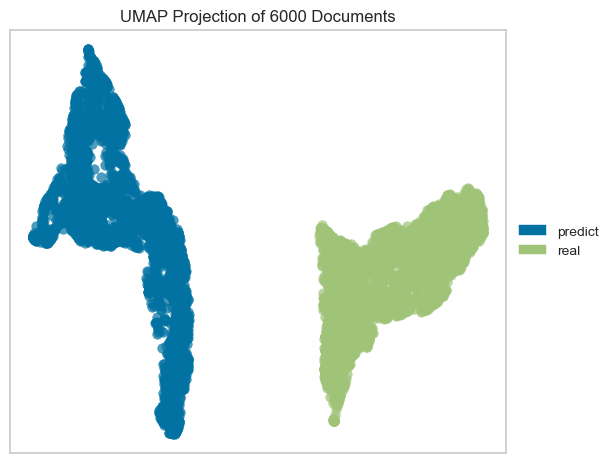

<AxesSubplot: title={'center': 'UMAP Projection of 6000 Documents'}>

In [ ]:
from yellowbrick.text import UMAPVisualizer

#umap = UMAPVisualizer(metric='cosine')
umap = UMAPVisualizer()
#yellowbrick
umap.fit(X,label)
umap.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


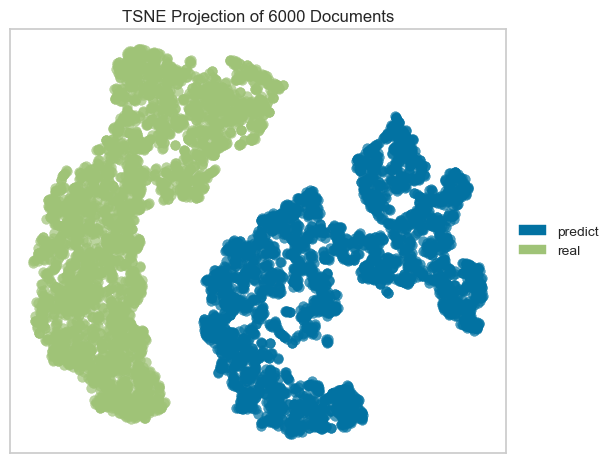

<AxesSubplot: title={'center': 'TSNE Projection of 6000 Documents'}>

In [ ]:
from yellowbrick.text import TSNEVisualizer

umap = TSNEVisualizer()
#yellowbrick
umap.fit(X,label)
umap.show()

# Transformer Model

In [ ]:
# Write a function to generate positional encodings

def generate_positional_encoding(max_length, embedding_dimension):
    pos_enc = np.array(
        [
            [pos / np.power(10000, 2 * (j // 2) / embedding_dimension) for j in range(embedding_dimension)]
            if pos != 0
            else np.zeros(embedding_dimension)
            for pos in range(max_length)
        ]
    )
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])  # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])  # dim 2i+1
    return pos_enc

In [ ]:
# Generate postional encodings for sequence length of 60 and embedding dimension of 256
positional_encodings = generate_positional_encoding(sequence_length, embedding_dim)

In [ ]:
# Compute the dot product of postion 1 with every other postions
dot_results = []
for idx in range(positional_encodings.shape[0]):
  dot_results.append(np.dot(positional_encodings[1], positional_encodings[idx]))

# to be change to be train....

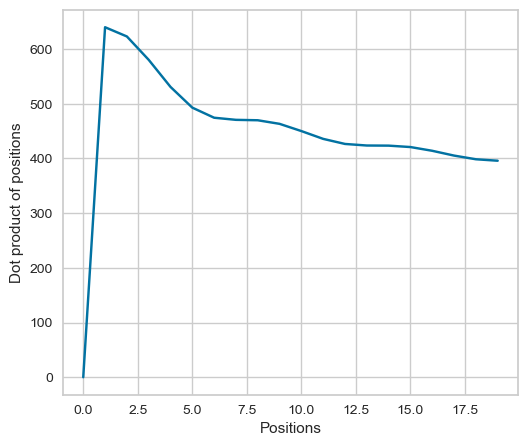

In [ ]:
# Plot the dot product results
fig = plt.figure(figsize=(20,5))
axs = fig.add_subplot(1,3,1)
axs.plot(np.arange(0, positional_encodings.shape[0]), dot_results)
axs.set_xlabel('Positions')
axs.set_ylabel('Dot product of positions')
plt.show()

In [ ]:
# Create a Positional Embedding layer that combines
# token embedding with positional encoding
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, input_dim):
      super().__init__()

      # Layer parameters
      self.sequence_length = sequence_length
      self.input_dim = input_dim

      # Token embedding Layer
      #self.token_embeddings = tf.keras.layers.Embedding(input_dim=input_dim, output_dim=output_dim)

    def call(self, inputs):
        # Generate token embeddings
        #embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = inputs          
        # Add positional encoding to the token embedding
        return embedded_tokens+generate_positional_encoding(self.sequence_length,self.input_dim)

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

In [ ]:
# Create the Transformer Encoder
class Encoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads):
        super().__init__()
        # Layer parameters
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        # MultiHeadAttention Layer - Self Attention
        self.attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        # Normalization Layer
        self.attention_norm = tf.keras.layers.LayerNormalization()

        # Dense projection
        self.dense_proj = tf.keras.Sequential(
            [tf.keras.layers.Dense(units=dense_dim, activation="relu"),
             tf.keras.layers.Dense(units=embed_dim)]
        )
        # Normalization Layer
        self.dense_projection_norm = tf.keras.layers.LayerNormalization()

    def call(self, inputs, mask=None):
        # Apply mask
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        
        # Compute Self Attention, set the query, key, and value as the inputs
        self_attention = self.attention(query=inputs, value=inputs, key=inputs, attention_mask=mask)
        # Apply Normalization + Residual connection
        self_attention = self.dense_projection_norm(self_attention+inputs)

        # Apply projection
        layer_output = self.dense_proj(self_attention)
        # Apply Normalization + Residual connection
        layer_output = self.dense_projection_norm(self_attention+layer_output)
        return layer_output

In [ ]:
############################
# Training Params
############################
learning_rate = 0.001
epochs = 20
embedding_dim = embedding_dim
dense_dim = embedding_dim*2
num_heads = int(embedding_dim/8) #problem here
num_heads = 4
# Free up memory
tf.keras.backend.clear_session()

# Build the model
# Model input
inputs_eng = tf.keras.Input(shape=[None])
inputs_spa = tf.keras.Input(shape=[None])

# Build the Encoder
encoder_ip = PositionalEmbedding(sequence_length,embedding_dim)(inputs_eng)
encoder_op = Encoder(embedding_dim,dense_dim,num_heads)(encoder_ip)

# Build the Decoder
#decoder_ip = PositionalEmbedding(sequence_length,vocab_size,embedding_dim)(inputs_spa)
#decoder_op = Decoder(embedding_dim,dense_dim,num_heads)(decoder_ip,encoder_op)
#decoder_op = tf.keras.layers.Dropout(0.5)(decoder_op)

# Output Layer
output = tf.keras.layers.Dense(units=embedding_dim, activation="linear")(encoder_op)

# Create model
transformer_model = tf.keras.Model(inputs_eng, output)

StagingError: Exception encountered when calling layer "encoder" (type Encoder).

in user code:

    File "/var/folders/43/npchwnj92jqft6xf6pqvpjr40000gn/T/ipykernel_18013/2160439203.py", line 29, in call  *
        self_attention = self.attention(query=inputs, value=inputs, key=inputs, attention_mask=mask)
    File "/Users/loic/miniforge3/envs/tf/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/Users/loic/miniforge3/envs/tf/lib/python3.8/site-packages/keras/layers/activation/softmax.py", line 103, in call
        return backend.softmax(inputs, axis=self.axis[0])

    IndexError: Exception encountered when calling layer "softmax" "                 f"(type Softmax).
    
    tuple index out of range
    
    Call arguments received by layer "softmax" "                 f"(type Softmax):
      • inputs=tf.Tensor(shape=(20, 4), dtype=float32)
      • mask=tf.Tensor(shape=(None, 1, None), dtype=bool)


Call arguments received by layer "encoder" (type Encoder):
  • inputs=tf.Tensor(shape=(20, 1280), dtype=float32)
  • mask=tf.Tensor(shape=(None, None), dtype=bool)

In [ ]:
history = compile_and_fit(transformer_model, train_data)

In [ ]:
# Print the model architecture
model.summary()

In [ ]:
scdsqdqs

In [ ]:
# Optimizer use RMSprop
optimizer = 'RMSprop'
# Loss use sparse categorical crossentropy
loss = 'sparse_categorical_crossentropy'

# Compile
model.compile(loss=loss,optimizer=optimizer)

# Train model
start_time = time.time()
print("Training...")

execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)